In [1]:
pwd

'C:\\Users\\User\\Desktop\\Data and Predictive Models'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lightgbm import LGBMClassifier

In [2]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn import metrics

from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC

In [3]:
ccdata = pd.read_csv('BankChurners.csv')

In [4]:
ccdata.drop("CLIENTNUM",axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',axis=1,inplace=True)
ccdata.drop('Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',axis=1,inplace=True)
ccdata['Gender'].replace({'M':1,'F':0},inplace=True)
ccdata["Attrition_Flag"].replace({'Existing Customer':0,'Attrited Customer':1},inplace=True)
ccdata2 = pd.get_dummies(data=ccdata,columns=['Education_Level','Marital_Status',"Income_Category",'Card_Category'],drop_first=True)
ccdata2.drop(['Avg_Open_To_Buy','Customer_Age','Total_Trans_Ct','Months_on_book','Total_Amt_Chng_Q4_Q1'],axis=1,inplace=True)

In [5]:
X = ccdata2.drop("Attrition_Flag",axis=1)
y = ccdata2['Attrition_Flag']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

## hyperparameter optimization

In [53]:
lgbm_r = LGBMClassifier(application='binary')

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
parameter_grid = [
    {
        'n_estimators':np.arange(100,200,50),
        'boosting_type':['gbdt','rf','dart','goss'],
        'max_depth':np.arange(5,30,5),
        'min_data_in_leaf':np.arange(30,100,10),
        'num_leaves': np.arange(5,30,5)**2,
        'is_unbalance':['True','False']
    }
]

In [56]:
clf = GridSearchCV(lgbm_r, param_grid = parameter_grid, cv = 5, verbose = True, n_jobs = -1)

In [57]:
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 2800 candidates, totalling 14000 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.92367225 0.92367245 0.92367245 ... 0.93679459 0.93679459 0.93679459]
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


In [58]:
results = pd.DataFrame(clf.cv_results_)

In [59]:
best_clf.best_estimator_

LGBMClassifier(application='binary', is_unbalance='False', max_depth=5,
               min_data_in_leaf=60, n_estimators=150, num_leaves=100)

In [61]:
best_clf.best_score_

0.9445538907463572

In [48]:
best_clf.best_params_

{'boosting_type': 'gbdt',
 'max_depth': 5,
 'min_data_in_leaf': 60,
 'n_estimators': 150,
 'num_leaves': 100}

## testing

In [7]:
from lightmodule import lgbm
#lgbm module consists of
#classification report, confusion matrix, KPI_summary, training & testing predictive probabilities
#training and testing log loss, feature_importance

lightmodule.py is being imported into another module


In [8]:
light1 = lgbm(X_train,X_test,y_train,y_test)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


In [9]:
#SMOTENC uses k-nearest neighbour algo to create synthetic samples 
#"Note - SMOTENC takes into consideration categorical and continuous variables"
from imblearn.over_sampling import SMOTE

#X= ccdata2.drop('Attrition_Flag',axis='columns')
#y= ccdata2['Attrition_Flag']
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm, y_sm = smote.fit_resample(X_train,y_train)

y_sm.value_counts()
#generate train test split first then do resampling only on training set

0    5949
1    5949
Name: Attrition_Flag, dtype: int64

In [10]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train,y_train)
y_train3.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

## post-feature selection

                     Feature_names  Importances  cumsum
0                  Total_Trans_Amt          653     653
1              Total_Ct_Chng_Q4_Q1          368    1021
2                     Credit_Limit          301    1322
3              Total_Revolving_Bal          280    1602
4         Total_Relationship_Count          192    1794
5            Contacts_Count_12_mon          145    1939
6            Avg_Utilization_Ratio          139    2078
7           Months_Inactive_12_mon          126    2204
8                  Dependent_count          101    2305
9           Marital_Status_Married           45    2350
10                          Gender           44    2394
11   Education_Level_Post-Graduate           20    2414
12           Marital_Status_Single           18    2432
13    Income_Category_$80K - $120K           15    2447
14     Income_Category_$40K - $60K           14    2461
15         Education_Level_Unknown           12    2473
16          Marital_Status_Unknown           12 

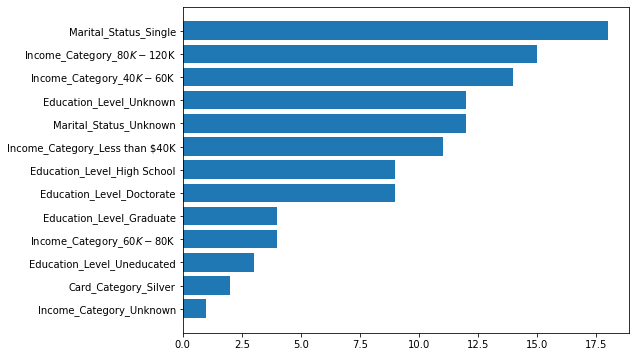

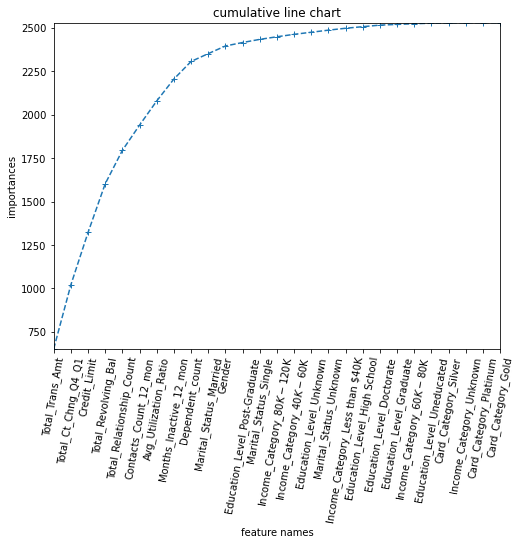

In [11]:
light1.feature_importance()

In [12]:
PS_X_train = X_train.drop(['Gender',
                                 'Education_Level_Post-Graduate',
                                 'Marital_Status_Single',
                                 'Income_Category_$80K - $120K',
                                 'Income_Category_$40K - $60K',
                                 'Education_Level_Unknown',
                                 'Marital_Status_Unknown',
                                 'Income_Category_Less than $40K',
                                 'Education_Level_High School',
                                 'Education_Level_Doctorate',
                                 'Education_Level_Graduate',
                                 'Income_Category_$60K - $80K',
                                 'Education_Level_Uneducated',
                                 'Card_Category_Silver',
                                 'Income_Category_Unknown',
                                 'Card_Category_Gold',
                                 'Card_Category_Platinum'],
                                  axis = 1)

PS_X_test = X_test.drop(['Gender',
                         'Education_Level_Post-Graduate',
                         'Marital_Status_Single',
                         'Income_Category_$80K - $120K',
                         'Income_Category_$40K - $60K',
                         'Education_Level_Unknown',
                         'Marital_Status_Unknown',
                         'Income_Category_Less than $40K',
                         'Education_Level_High School',
                         'Education_Level_Doctorate',
                         'Education_Level_Graduate',
                         'Income_Category_$60K - $80K',
                         'Education_Level_Uneducated',
                         'Card_Category_Silver',
                         'Income_Category_Unknown',
                         'Card_Category_Gold',
                         'Card_Category_Platinum'],
                          axis = 1)

In [13]:
PS_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7088 entries, 4124 to 4752
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dependent_count           7088 non-null   int64  
 1   Total_Relationship_Count  7088 non-null   int64  
 2   Months_Inactive_12_mon    7088 non-null   int64  
 3   Contacts_Count_12_mon     7088 non-null   int64  
 4   Credit_Limit              7088 non-null   float64
 5   Total_Revolving_Bal       7088 non-null   int64  
 6   Total_Trans_Amt           7088 non-null   int64  
 7   Total_Ct_Chng_Q4_Q1       7088 non-null   float64
 8   Avg_Utilization_Ratio     7088 non-null   float64
 9   Marital_Status_Married    7088 non-null   uint8  
dtypes: float64(3), int64(6), uint8(1)
memory usage: 560.7 KB


In [14]:
smote = SMOTE(sampling_strategy='minority') 
#samplingstrat specifies whether to use the minority or majority value for under/over-sampling
X_sm2, y_sm2 = smote.fit_resample(PS_X_train,y_train)

y_sm2.value_counts()
#generate train test split first then do resampling only on training set

0    5949
1    5949
Name: Attrition_Flag, dtype: int64

In [15]:
##### With Pipeline Step resampling #####
over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)
X_train4, y_train4 = pipeline.fit_resample(PS_X_train,y_train)
y_train4.value_counts()

0    3965
1    2379
Name: Attrition_Flag, dtype: int64

In [16]:
from lightmodule import lgbm,lgbm_unbalanced

light1 = lgbm(X_train,X_test,y_train,y_test)
light2 = lgbm(X_sm,X_test,y_sm,y_test)
light3 = lgbm(X_train3,X_test,y_train3,y_test)
light4 = lgbm(PS_X_train, PS_X_test,y_train,y_test)
light5 = lgbm(X_sm2, PS_X_test, y_sm2,y_test)
light6 = lgbm(X_train4, PS_X_test, y_train4,y_test)
light7 = lgbm_unbalanced(X_train,X_test,y_train,y_test)
light8 = lgbm_unbalanced(X_sm, X_test, y_sm, y_test)
light9 = lgbm_unbalanced(X_train3,X_test,y_train3,y_test)
light10 = lgbm_unbalanced(PS_X_train, PS_X_test,y_train,y_test)
light11 = lgbm_unbalanced(X_sm2, PS_X_test, y_sm2,y_test)
light12 = lgbm_unbalanced(X_train4, PS_X_test, y_train4,y_test)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min

In [17]:
ls10 = [light1,light2,light3,light4,light5,light6,light7,light8,light9,light10,light11,light12]
[print('light{}: '.format(i+1),x.f2_score) for i,x in enumerate(ls10)]

light1:  0.8333333333333334
light2:  0.8333333333333335
light3:  0.8687800963081862
light4:  0.8412567176519222
light5:  0.8615324776351614
light6:  0.8580922595777951
light7:  0.8793576184880533
light8:  0.8333333333333335
light9:  0.8681232930159969
light10:  0.8751458576429404
light11:  0.8615324776351614
light12:  0.8680688336520077


[None, None, None, None, None, None, None, None, None, None, None, None]

In [18]:
light7.KPI_summary()

accuracy score =  93.72 %
recall =  92.01 %
precision =  74.71 %
f2_score =  87.94 %
training accuracy =  95.67 %
testing accuracy =  93.72 %


[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
                     Feature_names  Importances  cumsum
0                  Total_Trans_Amt          676     676
1              Total_Ct_Chng_Q4_Q1          344    1020
2                     Credit_Limit          322    1342
3              Total_Revolving_Bal          

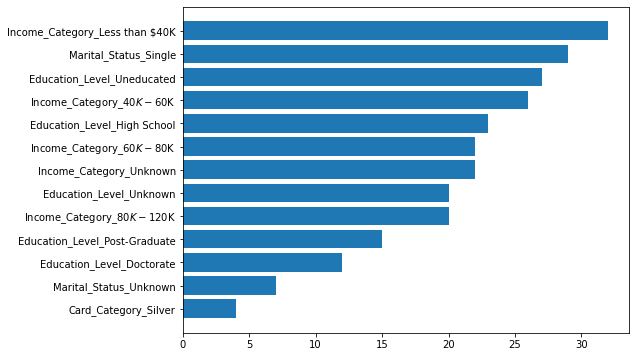

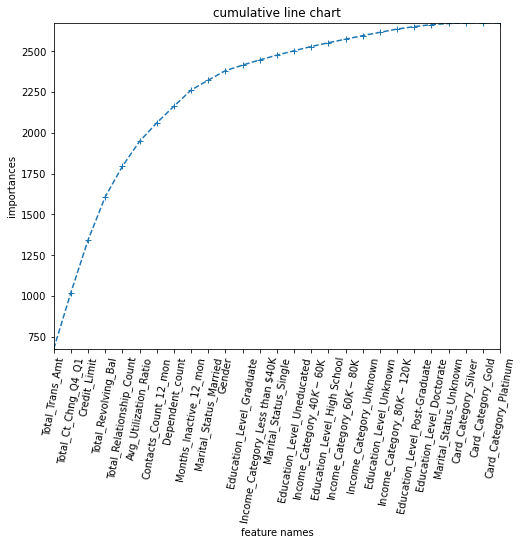

                     Feature_names  Importances  cumsum
0                  Total_Trans_Amt          676     676
1              Total_Ct_Chng_Q4_Q1          344    1020
2                     Credit_Limit          322    1342
3              Total_Revolving_Bal          265    1607
4         Total_Relationship_Count          187    1794
5            Avg_Utilization_Ratio          153    1947
6            Contacts_Count_12_mon          113    2060
7                  Dependent_count          102    2162
8           Months_Inactive_12_mon           99    2261
9           Marital_Status_Married           61    2322
10                          Gender           58    2380
11        Education_Level_Graduate           34    2414
12  Income_Category_Less than $40K           32    2446
13           Marital_Status_Single           29    2475
14      Education_Level_Uneducated           27    2502
15     Income_Category_$40K - $60K           26    2528
16     Education_Level_High School           23 

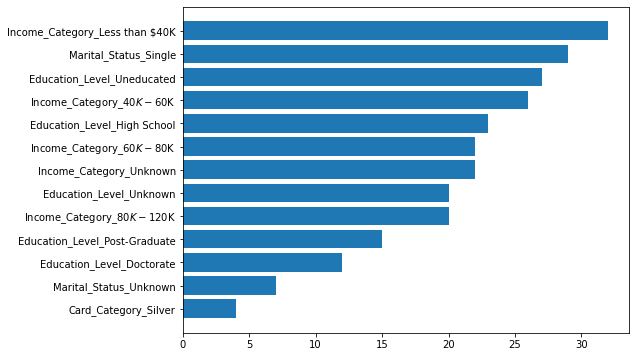

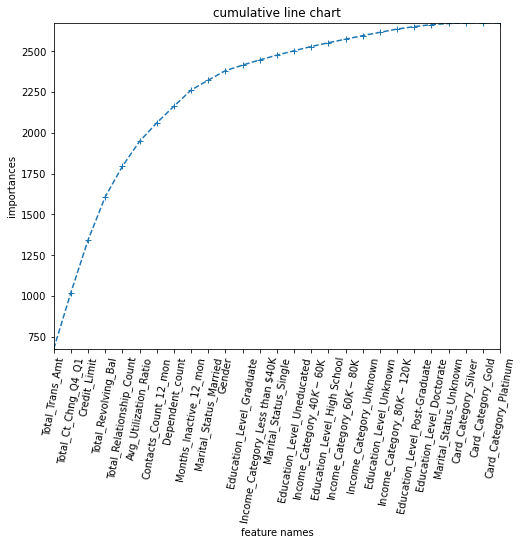

                     Feature_names  Importances  cumsum
0                  Total_Trans_Amt          676     676
1              Total_Ct_Chng_Q4_Q1          344    1020
2                     Credit_Limit          322    1342
3              Total_Revolving_Bal          265    1607
4         Total_Relationship_Count          187    1794
5            Avg_Utilization_Ratio          153    1947
6            Contacts_Count_12_mon          113    2060
7                  Dependent_count          102    2162
8           Months_Inactive_12_mon           99    2261
9           Marital_Status_Married           61    2322
10                          Gender           58    2380
11        Education_Level_Graduate           34    2414
12  Income_Category_Less than $40K           32    2446
13           Marital_Status_Single           29    2475
14      Education_Level_Uneducated           27    2502
15     Income_Category_$40K - $60K           26    2528
16     Education_Level_High School           23 

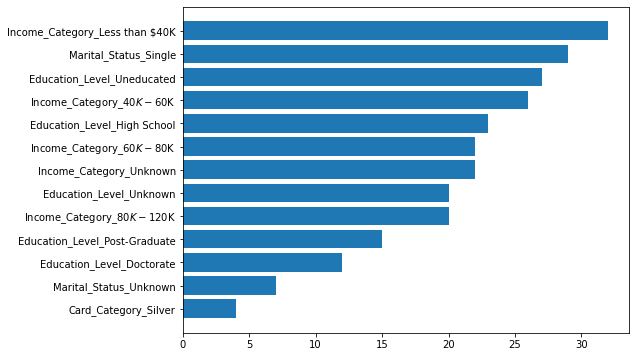

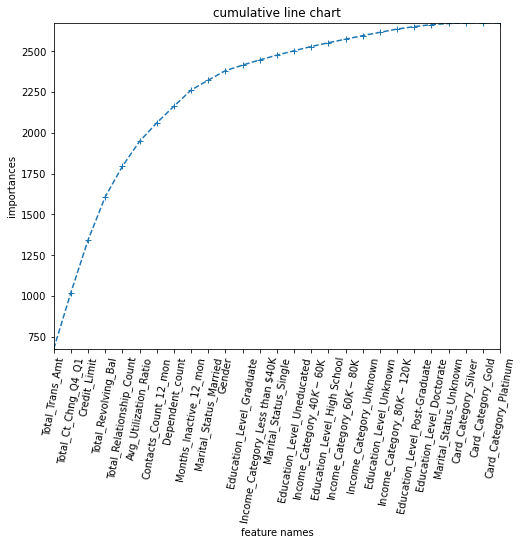

                     Feature_names  Importances  cumsum
0                  Total_Trans_Amt          660     660
1              Total_Ct_Chng_Q4_Q1          333     993
2                     Credit_Limit          310    1303
3              Total_Revolving_Bal          294    1597
4         Total_Relationship_Count          203    1800
5            Avg_Utilization_Ratio          165    1965
6            Contacts_Count_12_mon          112    2077
7                  Dependent_count           99    2176
8           Months_Inactive_12_mon           92    2268
9                           Gender           63    2331
10          Marital_Status_Married           62    2393
11        Education_Level_Graduate           38    2431
12           Marital_Status_Single           31    2462
13     Education_Level_High School           27    2489
14      Education_Level_Uneducated           26    2515
15     Income_Category_$40K - $60K           26    2541
16  Income_Category_Less than $40K           24 

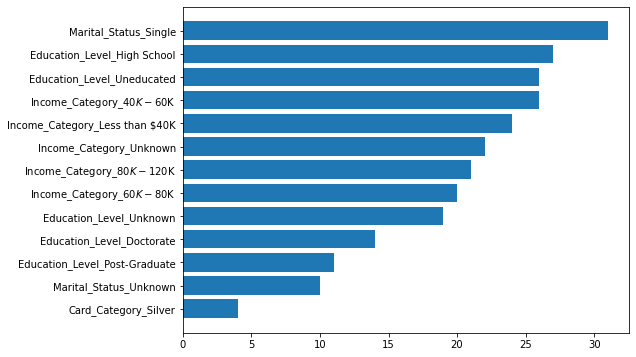

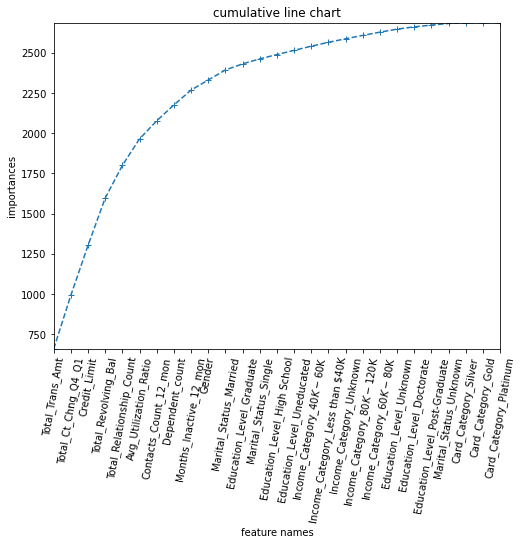

                     Feature_names  Importances  cumsum
0                  Total_Trans_Amt          660     660
1              Total_Ct_Chng_Q4_Q1          333     993
2                     Credit_Limit          310    1303
3              Total_Revolving_Bal          294    1597
4         Total_Relationship_Count          203    1800
5            Avg_Utilization_Ratio          165    1965
6            Contacts_Count_12_mon          112    2077
7                  Dependent_count           99    2176
8           Months_Inactive_12_mon           92    2268
9                           Gender           63    2331
10          Marital_Status_Married           62    2393
11        Education_Level_Graduate           38    2431
12           Marital_Status_Single           31    2462
13     Education_Level_High School           27    2489
14      Education_Level_Uneducated           26    2515
15     Income_Category_$40K - $60K           26    2541
16  Income_Category_Less than $40K           24 

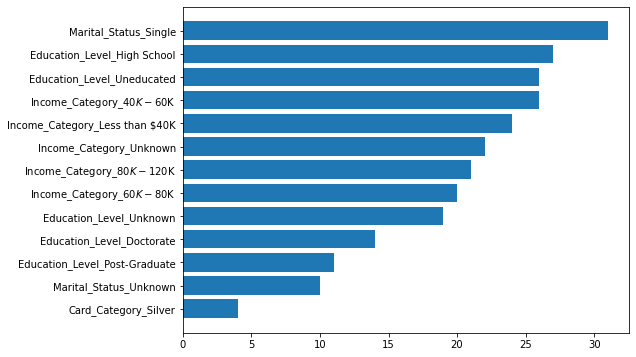

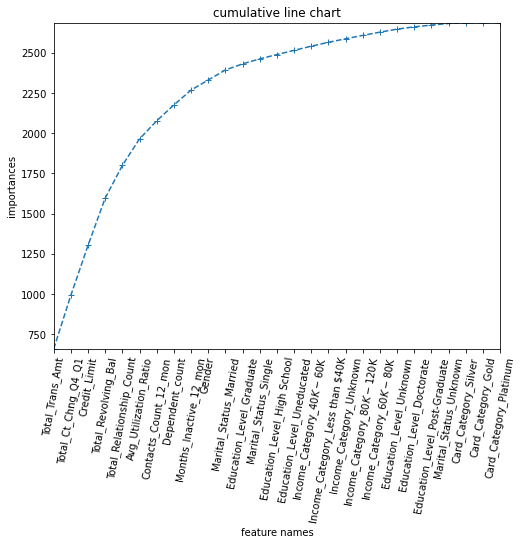

                     Feature_names  Importances  cumsum
0                  Total_Trans_Amt          660     660
1              Total_Ct_Chng_Q4_Q1          333     993
2                     Credit_Limit          310    1303
3              Total_Revolving_Bal          294    1597
4         Total_Relationship_Count          203    1800
5            Avg_Utilization_Ratio          165    1965
6            Contacts_Count_12_mon          112    2077
7                  Dependent_count           99    2176
8           Months_Inactive_12_mon           92    2268
9                           Gender           63    2331
10          Marital_Status_Married           62    2393
11        Education_Level_Graduate           38    2431
12           Marital_Status_Single           31    2462
13     Education_Level_High School           27    2489
14      Education_Level_Uneducated           26    2515
15     Income_Category_$40K - $60K           26    2541
16  Income_Category_Less than $40K           24 

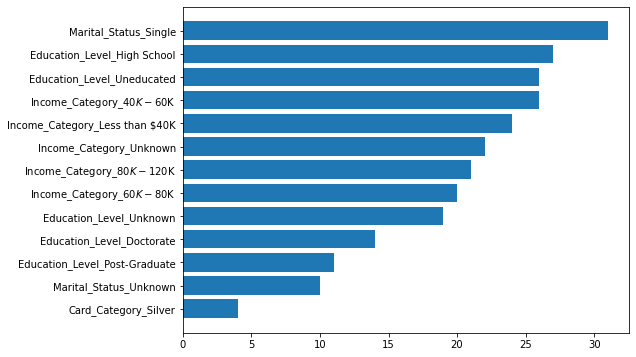

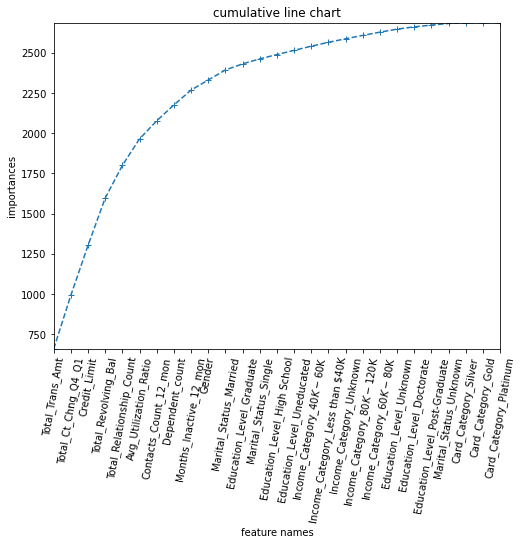

[None, None, None, None, None, None]

In [19]:
light1 = lgbm(X_train,X_test,y_train,y_test)
light2 = lgbm(X_sm,X_test,y_sm,y_test)
light3 = lgbm(X_train3,X_test,y_train3,y_test)
light7 = lgbm_unbalanced(X_train,X_test,y_train,y_test)
light8 = lgbm_unbalanced(X_sm, X_test, y_sm, y_test)
light9 = lgbm_unbalanced(X_train3,X_test,y_train3,y_test)

ls10 = [light1,light2,light3,light7,light8,light9]
[x.feature_importance() for x in ls10]

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
   index             Feature_names  Importances
0      6           Total_Trans_Amt          722
1      7       Total_Ct_Chng_Q4_Q1          389
2      4              Credit_Limit          353
3      5       Total_Revolving_Bal          324
4      1  Total_Relationship

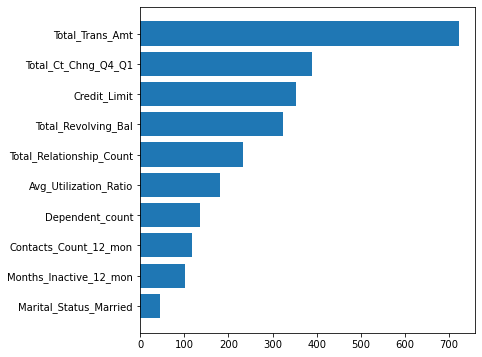



   index             Feature_names  Importances
0      6           Total_Trans_Amt          722
1      7       Total_Ct_Chng_Q4_Q1          389
2      4              Credit_Limit          353
3      5       Total_Revolving_Bal          324
4      1  Total_Relationship_Count          232
5      8     Avg_Utilization_Ratio          182
6      0           Dependent_count          136
7      3     Contacts_Count_12_mon          117
8      2    Months_Inactive_12_mon          101
9      9    Marital_Status_Married           45 



<Figure size 432x288 with 0 Axes>

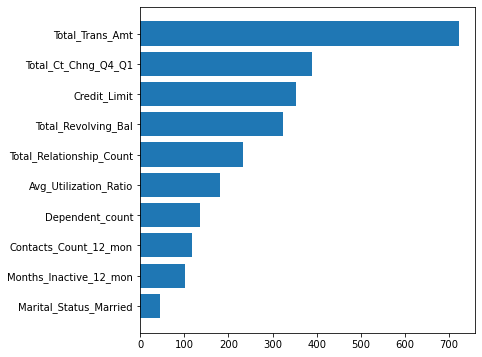



   index             Feature_names  Importances
0      6           Total_Trans_Amt          722
1      7       Total_Ct_Chng_Q4_Q1          389
2      4              Credit_Limit          353
3      5       Total_Revolving_Bal          324
4      1  Total_Relationship_Count          232
5      8     Avg_Utilization_Ratio          182
6      0           Dependent_count          136
7      3     Contacts_Count_12_mon          117
8      2    Months_Inactive_12_mon          101
9      9    Marital_Status_Married           45 



<Figure size 432x288 with 0 Axes>

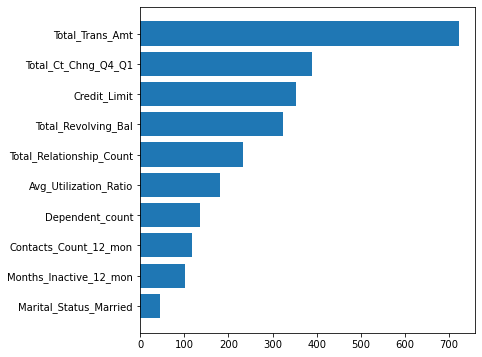



   index             Feature_names  Importances
0      6           Total_Trans_Amt          722
1      7       Total_Ct_Chng_Q4_Q1          385
2      4              Credit_Limit          355
3      5       Total_Revolving_Bal          334
4      1  Total_Relationship_Count          242
5      8     Avg_Utilization_Ratio          181
6      0           Dependent_count          117
7      3     Contacts_Count_12_mon          114
8      2    Months_Inactive_12_mon          100
9      9    Marital_Status_Married           53 



<Figure size 432x288 with 0 Axes>

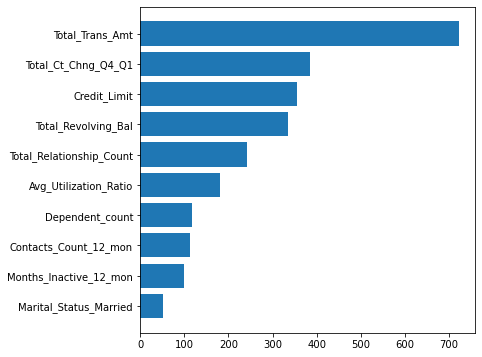



   index             Feature_names  Importances
0      6           Total_Trans_Amt          722
1      7       Total_Ct_Chng_Q4_Q1          385
2      4              Credit_Limit          355
3      5       Total_Revolving_Bal          334
4      1  Total_Relationship_Count          242
5      8     Avg_Utilization_Ratio          181
6      0           Dependent_count          117
7      3     Contacts_Count_12_mon          114
8      2    Months_Inactive_12_mon          100
9      9    Marital_Status_Married           53 



<Figure size 432x288 with 0 Axes>

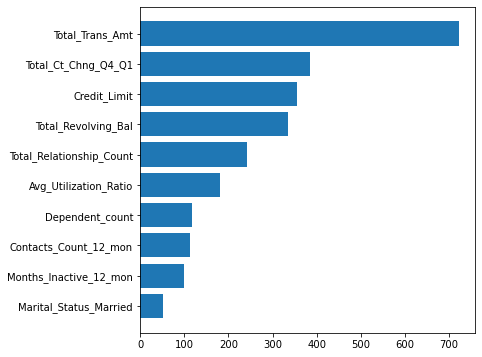



   index             Feature_names  Importances
0      6           Total_Trans_Amt          722
1      7       Total_Ct_Chng_Q4_Q1          385
2      4              Credit_Limit          355
3      5       Total_Revolving_Bal          334
4      1  Total_Relationship_Count          242
5      8     Avg_Utilization_Ratio          181
6      0           Dependent_count          117
7      3     Contacts_Count_12_mon          114
8      2    Months_Inactive_12_mon          100
9      9    Marital_Status_Married           53 



<Figure size 432x288 with 0 Axes>

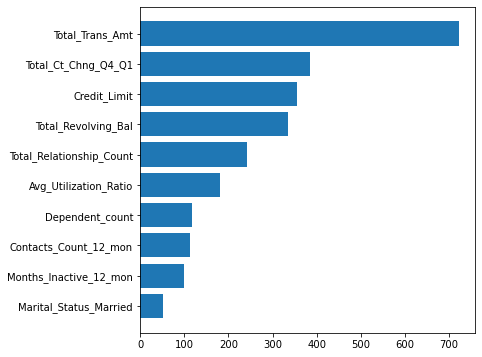

[None, None, None, None, None, None]

<Figure size 432x288 with 0 Axes>

In [20]:
light4 = lgbm(PS_X_train, PS_X_test,y_train,y_test)
light5 = lgbm(X_sm2, PS_X_test, y_sm2,y_test)
light6 = lgbm(X_train4, PS_X_test, y_train4,y_test)
light10 = lgbm_unbalanced(PS_X_train, PS_X_test,y_train,y_test)
light11 = lgbm_unbalanced(X_sm2, PS_X_test, y_sm2,y_test)
light12 = lgbm_unbalanced(X_train4, PS_X_test, y_train4,y_test)

ls11 = [light4,light5,light6,light10,light11,light12]

[x.feature_importance() for x in ls11]

## Model Interpretability using LIME

In [20]:
light7 = lgbm_unbalanced(X_train,X_test,y_train,y_test)

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


In [21]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(light7.x_train.values, mode='classification',feature_names=light7.x_train.columns,
                                 discretize_continuous=True)

In [22]:
pred_proba_test = pd.DataFrame(light7.pred_proba_test)

In [23]:
x_test = light7.x_test.reset_index().drop('index',axis=1)

In [24]:
merge1 = x_test.join(pred_proba_test)

In [25]:
merge2 = merge1.sort_values(by=1).reset_index().drop('index',axis=1)
merge2

Gender  Dependent_count  Total_Relationship_Count  \
0          0                4                         6   
1          1                4                         4   
2          1                3                         5   
3          0                1                         4   
4          0                1                         6   
...      ...              ...                       ...   
3034       0                3                         1   
3035       0                3                         2   
3036       0                2                         1   
3037       1                3                         2   
3038       1                2                         2   

      Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                          1                      3       15987.0   
1                          3                      0       31302.0   
2                          2                      0       22352.0   
3                          1                      0        3174.0   
4                          3                      2        2324.0   
...                      ...                    ...           ...   
3034                       4                      3        8516.0   
3035                       2                      3        1508.0   
3036                       3                      5        1883.0   
3037                       3                      4        3100.0   
3038                       3                      4        8906.0   

      Total_Revolving_Bal  Total_Trans_Amt  Total_Ct_Chng_Q4_Q1  \
0                    1648             1436                1.250   
1                    1953             1564                2.182   
2                    2517             1350                1.182   
3                    1951             1243                0.611   
4                    1576             1272                1.312   
...                   ...              ...                  ...   
3034                    0             2189                0.276   
3035                    0             1990                0.192   
3036                  400             1954                0.500   
3037                 2517              694                0.200   
3038                    0              809                0.250   

      Avg_Utilization_Ratio  ...  Income_Category_$40K - $60K  \
0                     0.103  ...                            0   
1                     0.062  ...                            0   
2                     0.113  ...                            0   
3                     0.615  ...                            0   
4                     0.678  ...                            0   
...                     ...  ...                          ...   
3034                  0.000  ...                            0   
3035                  0.000  ...                            0   
3036                  0.212  ...                            0   
3037                  0.812  ...                            0   
3038                  0.000  ...                            0   

      Income_Category_$60K - $80K  Income_Category_$80K - $120K  \
0                               0                             0   
1                               0                             1   
2                               1                             0   
3                               0                             0   
4                               0                             0   
...                           ...                           ...   
3034                            0                             0   
3035                            0                             0   
3036                            0                             0   
3037                            1                             0   
3038                            0                             0   

      Income_Category_Less than $40K  Income_Category_Unknown  \
0           

In [26]:
test_data = merge2.drop([0,1],axis=1)
test_data

Gender  Dependent_count  Total_Relationship_Count  \
0          0                4                         6   
1          1                4                         4   
2          1                3                         5   
3          0                1                         4   
4          0                1                         6   
...      ...              ...                       ...   
3034       0                3                         1   
3035       0                3                         2   
3036       0                2                         1   
3037       1                3                         2   
3038       1                2                         2   

      Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                          1                      3       15987.0   
1                          3                      0       31302.0   
2                          2                      0       22352.0   
3                          1                      0        3174.0   
4                          3                      2        2324.0   
...                      ...                    ...           ...   
3034                       4                      3        8516.0   
3035                       2                      3        1508.0   
3036                       3                      5        1883.0   
3037                       3                      4        3100.0   
3038                       3                      4        8906.0   

      Total_Revolving_Bal  Total_Trans_Amt  Total_Ct_Chng_Q4_Q1  \
0                    1648             1436                1.250   
1                    1953             1564                2.182   
2                    2517             1350                1.182   
3                    1951             1243                0.611   
4                    1576             1272                1.312   
...                   ...              ...                  ...   
3034                    0             2189                0.276   
3035                    0             1990                0.192   
3036                  400             1954                0.500   
3037                 2517              694                0.200   
3038                    0              809                0.250   

      Avg_Utilization_Ratio  ...  Marital_Status_Single  \
0                     0.103  ...                      1   
1                     0.062  ...                      1   
2                     0.113  ...                      1   
3                     0.615  ...                      0   
4                     0.678  ...                      0   
...                     ...  ...                    ...   
3034                  0.000  ...                      1   
3035                  0.000  ...                      0   
3036                  0.212  ...                      1   
3037                  0.812  ...                      0   
3038                  0.000  ...                      0   

      Marital_Status_Unknown  Income_Category_$40K - $60K  \
0                          0                            0   
1                          0                            0   
2                          0                            0   
3                          0                            0   
4                          0                            0   
...                      ...                          ...   
3034                       0                            0   
3035                       0                            0   
3036                       0                            0   
3037                       0                            0   
3038                       0                            0   

      Income_Category_$60K - $80K  Income_Category_$80K - $120K  \
0                               0                             0   
1                               0                             1   
2                   

In [27]:
from functools import partial

def model_pred_prob(X,model):
    return model.predict_proba(X)

## LIME test 1

### choosing the observation to explain

In [28]:
merge2[(merge2['Total_Trans_Amt']>9000) & (merge2[1]>0.5)][['Total_Trans_Amt',1]]

Total_Trans_Amt         1
2542             9102  0.723887
2647             9138  0.875036
2665            12025  0.899466
2674             9226  0.905722
2697             9105  0.917462
2702             9195  0.922412
2721             9658  0.936956
2762             9274  0.955244
2791             9242  0.966795
2793             9338  0.966910
2843             9192  0.979274
2853             9404  0.980548
2893             9220  0.988345
2895             9931  0.988465
2896             9351  0.988674
2897             9772  0.988783

In [29]:
#Using customer at index 2665 with the highest total transaction amount

obs_1 = test_data.iloc[[2665],:]
print('model prediction:', light7.model.predict(obs_1))
merge2.iloc[2665,]

model prediction: [1]


Gender                                1.000000
Dependent_count                       2.000000
Total_Relationship_Count              1.000000
Months_Inactive_12_mon                3.000000
Contacts_Count_12_mon                 3.000000
Credit_Limit                      29038.000000
Total_Revolving_Bal                2295.000000
Total_Trans_Amt                   12025.000000
Total_Ct_Chng_Q4_Q1                   0.807000
Avg_Utilization_Ratio                 0.079000
Education_Level_Doctorate             0.000000
Education_Level_Graduate              0.000000
Education_Level_High School           0.000000
Education_Level_Post-Graduate         1.000000
Education_Level_Uneducated            0.000000
Education_Level_Unknown               0.000000
Marital_Status_Married                0.000000
Marital_Status_Single                 1.000000
Marital_Status_Unknown                0.000000
Income_Category_$40K - $60K           0.000000
Income_Category_$60K - $80K           1.000000
Income_Catego

### creating a LIME explainer function

In [30]:
def limexplainer(model,test_data,observation):
    
    light_pred_proba = partial(model_pred_prob,model=model)
    
    obs = test_data.iloc[[observation],:]
    
    print('model prediction: {}'.format(model.predict(obs)))
    
    explanation = explainer.explain_instance(obs.values[0],light_pred_proba)
    explanation.show_in_notebook(show_table=True,show_all=False)
    

In [31]:
limexplainer(light7.model,test_data,2665)

model prediction: [1]


In [38]:
lgbm_pred_proba_1 = partial(model_pred_prob,model=light7.model)
explanation1 = explainer.explain_instance(obs_1.values[0], lgbm_pred_proba_1)

In [39]:
explanation1.show_in_notebook(show_table=True, show_all=False)

In [40]:
explanation1.score

0.0892925251243164